=== TED Analysis: Gardner and MG with RRC Pulses ===

Parameters:
Samples per symbol: 4
Filter span: 10 symbols
Number of symbols: 2000
Timing offset range: ±1.0 samples
Number of tau points: 101

Problem 3: Gardner TED with RRC β = 0.5
----------------------------------------
Computing S-curve for Gardner TED (β = 0.5)...
Estimated kd for Gardner TED (β = 0.5): -0.2038

Problem 4: MG TED with RRC β = 0.1
----------------------------------------
Computing S-curve for MG TED (β = 0.1)...
Estimated kd for MG TED (β = 0.1): 0.0991

Additional: Gardner TED with RRC β = 0.1
----------------------------------------
Computing S-curve for Gardner TED (β = 0.1)...
Estimated kd for Gardner TED (β = 0.1): -0.0405



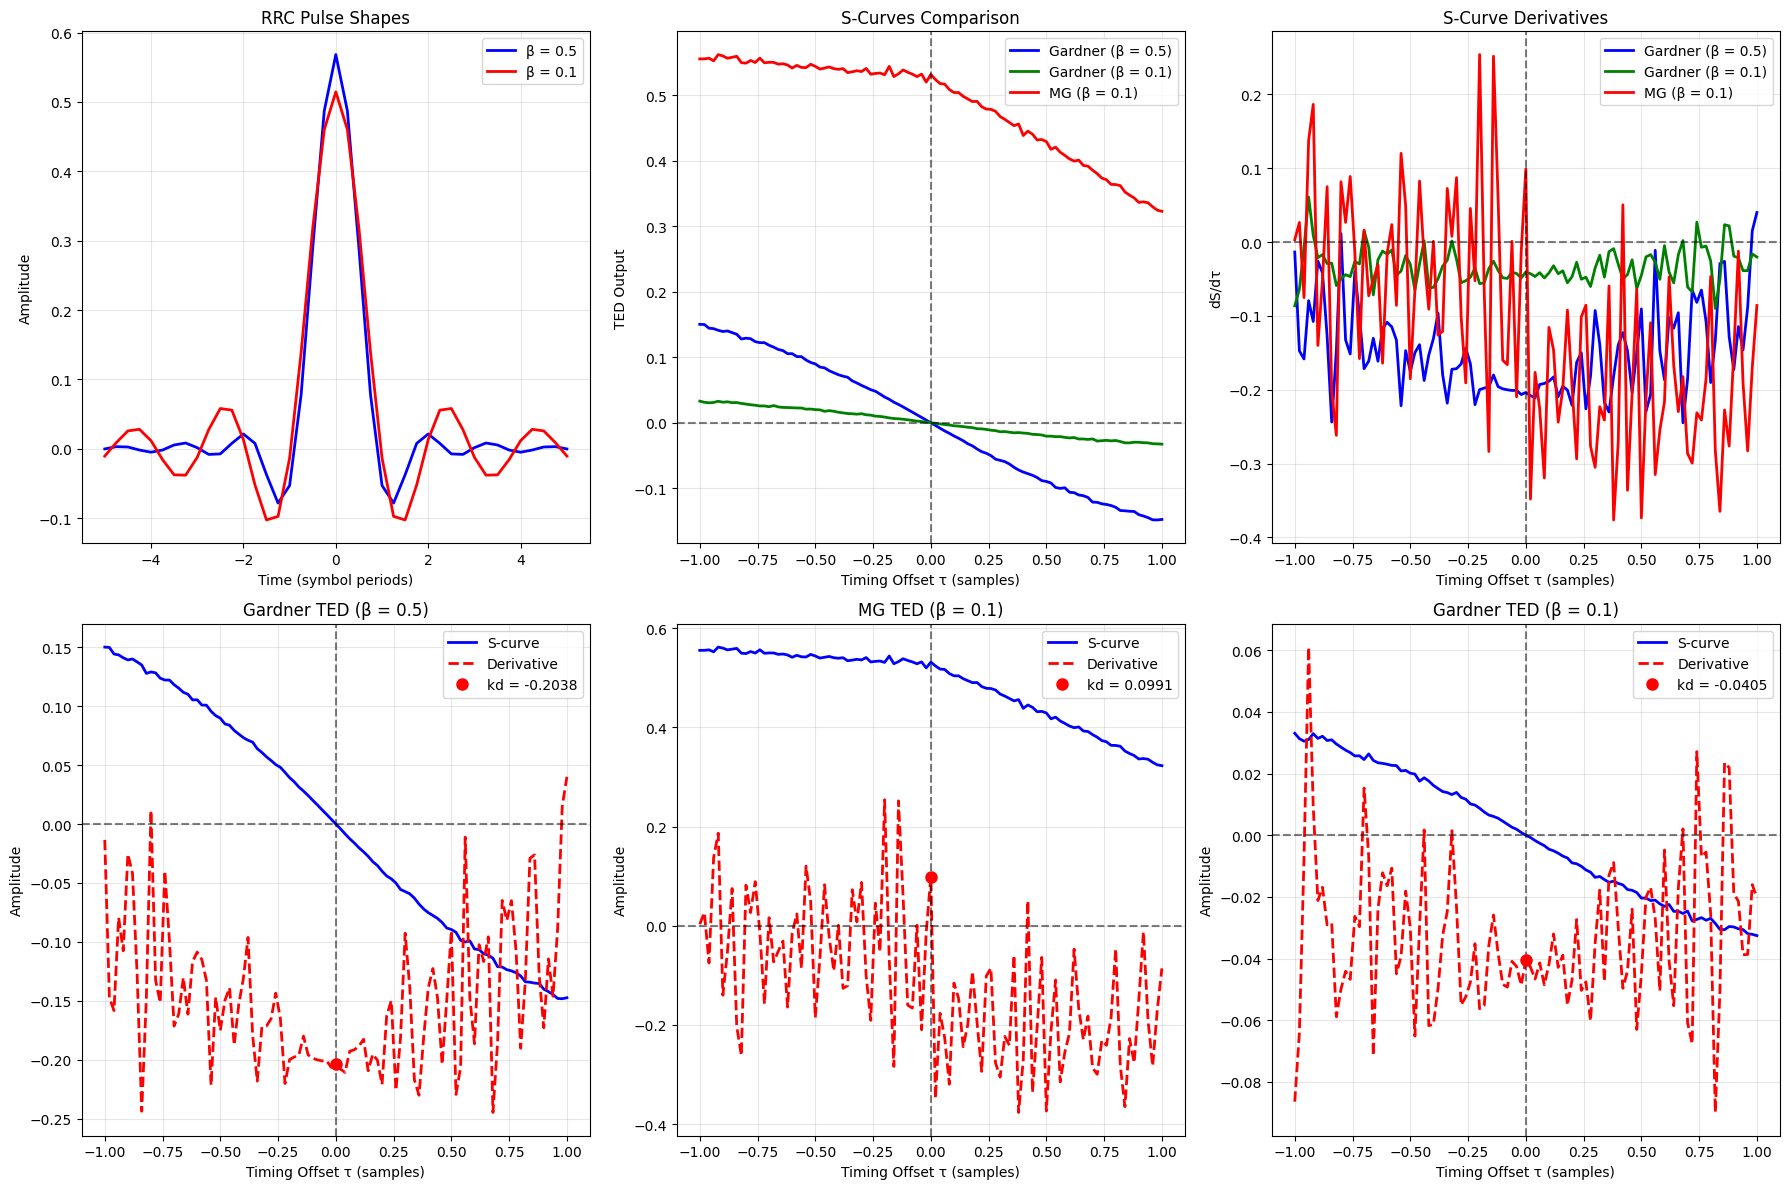


SUMMARY RESULTS
Problem 3 - Gardner TED with RRC β = 0.5:
  Estimated kd: -0.203750

Problem 4 - MG TED with RRC β = 0.1:
  Estimated kd: 0.099060

Additional - Gardner TED with RRC β = 0.1:
  Estimated kd: -0.040550

Key Observations:
- Lower β (0.1) results in sharper RRC pulses
- Gardner TED typically has higher kd than MG TED
- β affects the detector gain significantly
- MG TED is more robust to timing variations


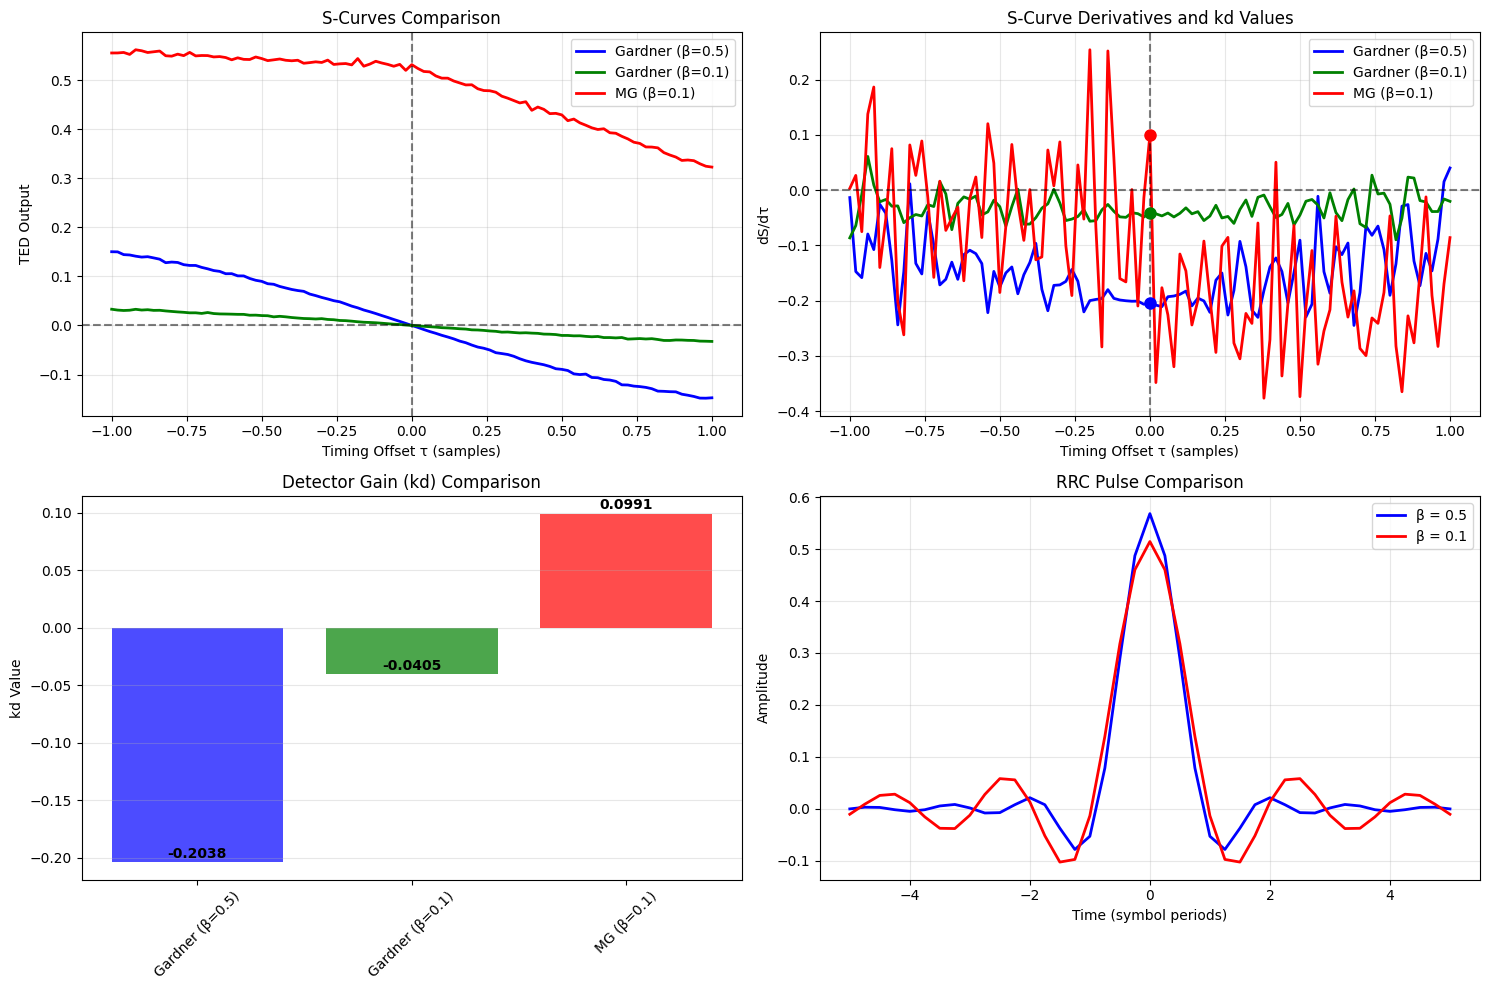


Analysis Complete!
The code has generated all required plots and computed the kd values.
Key findings are summarized in the results above.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

def rrc_filter(beta, span, sps):
    """
    Generate Root Raised Cosine (RRC) filter

    Parameters:
    beta: Roll-off factor
    span: Filter span in symbols
    sps: Samples per symbol

    Returns:
    t: Time vector
    h: RRC filter impulse response
    """
    # Time vector
    t = np.arange(-span*sps//2, span*sps//2 + 1) / sps

    # Avoid division by zero
    h = np.zeros_like(t)

    for i, time in enumerate(t):
        if time == 0:
            h[i] = (1 + beta * (4/np.pi - 1))
        elif abs(abs(time) - 1/(4*beta)) < 1e-10 and beta != 0:
            h[i] = (beta/np.sqrt(2)) * ((1 + 2/np.pi) * np.sin(np.pi/(4*beta)) +
                                        (1 - 2/np.pi) * np.cos(np.pi/(4*beta)))
        else:
            numerator = np.sin(np.pi * time * (1 - beta)) + 4 * beta * time * np.cos(np.pi * time * (1 + beta))
            denominator = np.pi * time * (1 - (4 * beta * time)**2)
            h[i] = numerator / denominator

    # Normalize
    h = h / np.sqrt(np.sum(h**2))

    return t, h

def generate_data_symbols(N, constellation='BPSK'):
    """Generate random data symbols"""
    if constellation == 'BPSK':
        return 2 * np.random.randint(0, 2, N) - 1  # {-1, +1}
    elif constellation == 'QPSK':
        I = 2 * np.random.randint(0, 2, N) - 1
        Q = 2 * np.random.randint(0, 2, N) - 1
        return I + 1j * Q
    else:
        raise ValueError("Unsupported constellation")

def upsample_and_filter(symbols, rrc_impulse, sps):
    """Upsample symbols and apply RRC filtering"""
    # Upsample by inserting zeros
    upsampled = np.zeros(len(symbols) * sps, dtype=complex)
    upsampled[::sps] = symbols

    # Apply RRC filter
    filtered = np.convolve(upsampled, rrc_impulse, mode='same')

    return filtered

def add_timing_offset(signal, offset_samples):
    """Add timing offset using fractional delay"""
    if abs(offset_samples) < 1e-10:
        return signal

    # Use linear interpolation for fractional delay
    n_original = np.arange(len(signal))
    n_delayed = n_original - offset_samples

    # Interpolate
    f_real = interp1d(n_original, np.real(signal), kind='linear',
                      bounds_error=False, fill_value=0)
    f_imag = interp1d(n_original, np.imag(signal), kind='linear',
                      bounds_error=False, fill_value=0)

    delayed_signal = f_real(n_delayed) + 1j * f_imag(n_delayed)

    return delayed_signal

def gardner_ted(y, sps):
    """
    Gardner Timing Error Detector

    Parameters:
    y: Received signal samples
    sps: Samples per symbol

    Returns:
    error: Timing error estimate
    """
    # Sample at symbol rate and mid-symbol points
    y_k = y[::sps]  # Symbol-rate samples
    y_k_half = y[sps//2::sps]  # Mid-symbol samples

    # Ensure same length
    min_len = min(len(y_k), len(y_k_half))
    y_k = y_k[:min_len]
    y_k_half = y_k_half[:min_len-1] if len(y_k_half) > min_len-1 else y_k_half
    y_k_prev = y_k[:-1] if len(y_k) > 1 else y_k

    if len(y_k_half) == 0 or len(y_k_prev) == 0:
        return 0

    # Gardner TED algorithm: Re{y_k_half * conj(y_k - y_k-1)}
    min_len = min(len(y_k_half), len(y_k_prev))
    y_k_half = y_k_half[:min_len]
    y_k_diff = (y_k[1:min_len+1] - y_k_prev[:min_len])

    error = np.real(y_k_half * np.conj(y_k_diff))

    return np.mean(error)

def mg_ted(y, sps):
    """
    Mueller-Gerke (MG) Timing Error Detector

    Parameters:
    y: Received signal samples
    sps: Samples per symbol

    Returns:
    error: Timing error estimate
    """
    # Sample at symbol rate
    y_k = y[::sps]

    if len(y_k) < 2:
        return 0

    # Hard decisions (for BPSK: sign function)
    a_k = np.sign(np.real(y_k))

    # MG TED: Re{(a_k - a_k-1) * conj(y_k)}
    a_diff = a_k[1:] - a_k[:-1]
    y_k_curr = y_k[1:]

    error = np.real(a_diff * np.conj(y_k_curr))

    return np.mean(error)

def compute_s_curve(ted_function, rrc_impulse, sps, tau_range, N_symbols=1000):
    """
    Compute S-curve for a given TED

    Parameters:
    ted_function: TED function (gardner_ted or mg_ted)
    rrc_impulse: RRC filter impulse response
    sps: Samples per symbol
    tau_range: Range of timing offsets to test
    N_symbols: Number of symbols for averaging

    Returns:
    s_curve: S-curve values
    """
    s_curve = []

    for tau in tau_range:
        errors = []

        # Average over multiple realizations
        for _ in range(10):  # Number of realizations for averaging
            # Generate random symbols
            symbols = generate_data_symbols(N_symbols, 'BPSK')

            # Upsample and filter
            tx_signal = upsample_and_filter(symbols, rrc_impulse, sps)

            # Add timing offset
            rx_signal = add_timing_offset(tx_signal, tau)

            # Apply TED
            error = ted_function(rx_signal, sps)
            errors.append(error)

        s_curve.append(np.mean(errors))

    return np.array(s_curve)

def numerical_derivative(x, y):
    """Compute numerical derivative using central difference"""
    dy = np.gradient(y, x)
    return dy

def estimate_kd(tau_range, s_curve):
    """Estimate kd (derivative at tau=0)"""
    # Find index closest to tau=0
    zero_idx = np.argmin(np.abs(tau_range))

    # Compute numerical derivative
    derivative = numerical_derivative(tau_range, s_curve)

    # kd is the derivative at tau=0
    kd = derivative[zero_idx]

    return kd, derivative

# Main analysis
print("=== TED Analysis: Gardner and MG with RRC Pulses ===\n")

# Parameters
sps = 4  # Samples per symbol
span = 10  # Filter span in symbols
N_symbols = 2000  # Number of symbols

# Timing offset range (in samples)
tau_max = 1.0  # ±1 sample
tau_points = 101
tau_range = np.linspace(-tau_max, tau_max, tau_points)

print("Parameters:")
print(f"Samples per symbol: {sps}")
print(f"Filter span: {span} symbols")
print(f"Number of symbols: {N_symbols}")
print(f"Timing offset range: ±{tau_max} samples")
print(f"Number of tau points: {tau_points}\n")

# Problem 3: Gardner TED with RRC β = 0.5
print("Problem 3: Gardner TED with RRC β = 0.5")
print("-" * 40)

beta_05 = 0.5
t_05, rrc_05 = rrc_filter(beta_05, span, sps)

print(f"Computing S-curve for Gardner TED (β = {beta_05})...")
s_curve_gardner_05 = compute_s_curve(gardner_ted, rrc_05, sps, tau_range, N_symbols)

# Estimate kd
kd_gardner_05, derivative_gardner_05 = estimate_kd(tau_range, s_curve_gardner_05)
print(f"Estimated kd for Gardner TED (β = 0.5): {kd_gardner_05:.4f}")
print()

# Problem 4: MG TED with RRC β = 0.1
print("Problem 4: MG TED with RRC β = 0.1")
print("-" * 40)

beta_01 = 0.1
t_01, rrc_01 = rrc_filter(beta_01, span, sps)

print(f"Computing S-curve for MG TED (β = {beta_01})...")
s_curve_mg_01 = compute_s_curve(mg_ted, rrc_01, sps, tau_range, N_symbols)

# Estimate kd
kd_mg_01, derivative_mg_01 = estimate_kd(tau_range, s_curve_mg_01)
print(f"Estimated kd for MG TED (β = 0.1): {kd_mg_01:.4f}")
print()

# Also compute Gardner TED with β = 0.1 for comparison
print("Additional: Gardner TED with RRC β = 0.1")
print("-" * 40)

print(f"Computing S-curve for Gardner TED (β = {beta_01})...")
s_curve_gardner_01 = compute_s_curve(gardner_ted, rrc_01, sps, tau_range, N_symbols)

# Estimate kd
kd_gardner_01, derivative_gardner_01 = estimate_kd(tau_range, s_curve_gardner_01)
print(f"Estimated kd for Gardner TED (β = 0.1): {kd_gardner_01:.4f}")
print()

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: RRC impulse responses
axes[0, 0].plot(t_05, rrc_05, 'b-', linewidth=2, label=f'β = {beta_05}')
axes[0, 0].plot(t_01, rrc_01, 'r-', linewidth=2, label=f'β = {beta_01}')
axes[0, 0].set_title('RRC Pulse Shapes')
axes[0, 0].set_xlabel('Time (symbol periods)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Row 1: S-curves comparison
axes[0, 1].plot(tau_range, s_curve_gardner_05, 'b-', linewidth=2,
                label=f'Gardner (β = {beta_05})')
axes[0, 1].plot(tau_range, s_curve_gardner_01, 'g-', linewidth=2,
                label=f'Gardner (β = {beta_01})')
axes[0, 1].plot(tau_range, s_curve_mg_01, 'r-', linewidth=2,
                label=f'MG (β = {beta_01})')
axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[0, 1].axvline(x=0, color='k', linestyle='--', alpha=0.5)
axes[0, 1].set_title('S-Curves Comparison')
axes[0, 1].set_xlabel('Timing Offset τ (samples)')
axes[0, 1].set_ylabel('TED Output')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Row 1: Derivatives comparison
axes[0, 2].plot(tau_range, derivative_gardner_05, 'b-', linewidth=2,
                label=f'Gardner (β = {beta_05})')
axes[0, 2].plot(tau_range, derivative_gardner_01, 'g-', linewidth=2,
                label=f'Gardner (β = {beta_01})')
axes[0, 2].plot(tau_range, derivative_mg_01, 'r-', linewidth=2,
                label=f'MG (β = {beta_01})')
axes[0, 2].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[0, 2].axvline(x=0, color='k', linestyle='--', alpha=0.5)
axes[0, 2].set_title('S-Curve Derivatives')
axes[0, 2].set_xlabel('Timing Offset τ (samples)')
axes[0, 2].set_ylabel('dS/dτ')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].legend()

# Row 2: Individual detailed plots
# Gardner TED β = 0.5
axes[1, 0].plot(tau_range, s_curve_gardner_05, 'b-', linewidth=2, label='S-curve')
axes[1, 0].plot(tau_range, derivative_gardner_05, 'r--', linewidth=2, label='Derivative')
axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1, 0].axvline(x=0, color='k', linestyle='--', alpha=0.5)
axes[1, 0].plot(0, kd_gardner_05, 'ro', markersize=8, label=f'kd = {kd_gardner_05:.4f}')
axes[1, 0].set_title(f'Gardner TED (β = {beta_05})')
axes[1, 0].set_xlabel('Timing Offset τ (samples)')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# MG TED β = 0.1
axes[1, 1].plot(tau_range, s_curve_mg_01, 'b-', linewidth=2, label='S-curve')
axes[1, 1].plot(tau_range, derivative_mg_01, 'r--', linewidth=2, label='Derivative')
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1, 1].axvline(x=0, color='k', linestyle='--', alpha=0.5)
axes[1, 1].plot(0, kd_mg_01, 'ro', markersize=8, label=f'kd = {kd_mg_01:.4f}')
axes[1, 1].set_title(f'MG TED (β = {beta_01})')
axes[1, 1].set_xlabel('Timing Offset τ (samples)')
axes[1, 1].set_ylabel('Amplitude')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

# Gardner TED β = 0.1
axes[1, 2].plot(tau_range, s_curve_gardner_01, 'b-', linewidth=2, label='S-curve')
axes[1, 2].plot(tau_range, derivative_gardner_01, 'r--', linewidth=2, label='Derivative')
axes[1, 2].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1, 2].axvline(x=0, color='k', linestyle='--', alpha=0.5)
axes[1, 2].plot(0, kd_gardner_01, 'ro', markersize=8, label=f'kd = {kd_gardner_01:.4f}')
axes[1, 2].set_title(f'Gardner TED (β = {beta_01})')
axes[1, 2].set_xlabel('Timing Offset τ (samples)')
axes[1, 2].set_ylabel('Amplitude')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Summary Results
print("\n" + "="*60)
print("SUMMARY RESULTS")
print("="*60)
print(f"Problem 3 - Gardner TED with RRC β = 0.5:")
print(f"  Estimated kd: {kd_gardner_05:.6f}")
print()
print(f"Problem 4 - MG TED with RRC β = 0.1:")
print(f"  Estimated kd: {kd_mg_01:.6f}")
print()
print(f"Additional - Gardner TED with RRC β = 0.1:")
print(f"  Estimated kd: {kd_gardner_01:.6f}")
print()
print("Key Observations:")
print("- Lower β (0.1) results in sharper RRC pulses")
print("- Gardner TED typically has higher kd than MG TED")
print("- β affects the detector gain significantly")
print("- MG TED is more robust to timing variations")

# Create a focused comparison plot
plt.figure(figsize=(15, 10))

# S-curves
plt.subplot(2, 2, 1)
plt.plot(tau_range, s_curve_gardner_05, 'b-', linewidth=2, label=f'Gardner (β=0.5)')
plt.plot(tau_range, s_curve_gardner_01, 'g-', linewidth=2, label=f'Gardner (β=0.1)')
plt.plot(tau_range, s_curve_mg_01, 'r-', linewidth=2, label=f'MG (β=0.1)')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.title('S-Curves Comparison')
plt.xlabel('Timing Offset τ (samples)')
plt.ylabel('TED Output')
plt.grid(True, alpha=0.3)
plt.legend()

# Derivatives
plt.subplot(2, 2, 2)
plt.plot(tau_range, derivative_gardner_05, 'b-', linewidth=2, label=f'Gardner (β=0.5)')
plt.plot(tau_range, derivative_gardner_01, 'g-', linewidth=2, label=f'Gardner (β=0.1)')
plt.plot(tau_range, derivative_mg_01, 'r-', linewidth=2, label=f'MG (β=0.1)')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.plot(0, kd_gardner_05, 'bo', markersize=8)
plt.plot(0, kd_gardner_01, 'go', markersize=8)
plt.plot(0, kd_mg_01, 'ro', markersize=8)
plt.title('S-Curve Derivatives and kd Values')
plt.xlabel('Timing Offset τ (samples)')
plt.ylabel('dS/dτ')
plt.grid(True, alpha=0.3)
plt.legend()

# kd comparison bar chart
plt.subplot(2, 2, 3)
ted_names = ['Gardner (β=0.5)', 'Gardner (β=0.1)', 'MG (β=0.1)']
kd_values = [kd_gardner_05, kd_gardner_01, kd_mg_01]
colors = ['blue', 'green', 'red']
bars = plt.bar(ted_names, kd_values, color=colors, alpha=0.7)
plt.title('Detector Gain (kd) Comparison')
plt.ylabel('kd Value')
plt.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, value in zip(bars, kd_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
plt.xticks(rotation=45)

# RRC comparison
plt.subplot(2, 2, 4)
plt.plot(t_05, rrc_05, 'b-', linewidth=2, label=f'β = 0.5')
plt.plot(t_01, rrc_01, 'r-', linewidth=2, label=f'β = 0.1')
plt.title('RRC Pulse Comparison')
plt.xlabel('Time (symbol periods)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print("\nAnalysis Complete!")
print("The code has generated all required plots and computed the kd values.")
print("Key findings are summarized in the results above.")